# BMTF input stubs fit with 4 group of stubs

## Imports and setup

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep

import os
import warnings

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, callbacks, regularizers

In [53]:
hep.style.use("CMS")

warnings.filterwarnings("ignore")

mpl.rcParams["figure.dpi"] = 70

In [54]:
print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

Training device: GPU


## Constants

In [55]:
USER = os.getenv("USER")

# FILE_PATH = "/eos/cms/store/cmst3/group/daql1scout/ml_data/run3/bmtf_stubs_refit/"
FILE_PATH = "/mnt/ml_data/run3/bmtf_stubs_refit/"

FILE_SAVE_DATA = "/mnt/ml_data/run3/bmtf_stubs_refit_dummy/Data3NN/"

FILE_NAME = "rereco"

OUT_PATH = "."
LOSS_FNAME = "losses_4.csv"

FIGSIZE = (12, 7)

petroff_10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', petroff_10)

## Classes

### Neural Network model for regression+classification task

In [56]:
class MultiTaskNN(tf.keras.Model):
    def __init__(self, architecture, reg_strength=0.01):
        super(MultiTaskNN, self).__init__()

        # Check if the architecture list has at least 2 values (input size and one hidden layer)
        if len(architecture) < 2:
            raise ValueError("Architecture must contain at least input size and one hidden layer.")

        self.layers_list = []

        # Iterate over the architecture list to dynamically create dense layers followed by batch normalization
        for i in range(1, len(architecture)):
            self.layers_list.append(layers.Dense(architecture[i], kernel_regularizer=regularizers.l2(reg_strength)))
            self.layers_list.append(layers.Activation('elu'))

        self.regression_head = layers.Dense(3, kernel_regularizer=regularizers.l2(reg_strength))  # for pt, eta, phi

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)

        reg_output = self.regression_head(x)
        return reg_output

### Custom Learning Rate scheduler

In [57]:
# Custom learning rate scheduler callback
class CustomLRScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self, 
        optimizer, 
        factor=0.5, 
        patience=5, 
        min_improvement=0.01, 
        verbose=True
    ):
        super(CustomLRScheduler, self).__init__()
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_improvement = min_improvement
        self.verbose = verbose
        self.best_loss = float('inf')
        self.patience_counter = 0

        
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.optimizer.lr.assign(self.min_lr)
        if epoch < self.decrease_epoch:
            self.increase_flag = True
        else:
            self.increase_flag = False


    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("val_loss")

        if loss:
            relative_improvement = (self.best_loss - loss) / self.best_loss

            if relative_improvement < self.min_improvement:
                self.patience_counter += 1
            else:
                self.patience_counter = 0
                self.best_loss = loss

            if self.patience_counter >= self.patience:
                self._decrease_lr()

    def _decrease_lr(self):
        old_lr = self.optimizer.lr.numpy()
        new_lr = old_lr * self.factor
        self.optimizer.lr.assign(new_lr)
        if self.verbose:
            print(f"Decreasing learning rate to {new_lr}")

# Read Data

In [58]:
#create datasets data_3
data_4 = pd.read_csv(FILE_SAVE_DATA + 'data_4s.csv')

In [59]:
data_4

,n_stubs,a_stNum,a_scNum,a_whNum,a_eta_1,a_qeta_1,a_eta_2,a_qeta_2,a_tag,a_phi,...,phiExtRecoSt2,chargeReco,ptL1,etaL1,phiL1,hwSignL1,info_a,info_b,info_c,info_d
0,4,1,8,1,7,0,7,0,1,-153,...,-2.10473,0,9.0,0.598125,-2.09440,1,1,2,3,4
1,4,1,4,-1,-46,1,255,0,1,-427,...,2.01145,0,10.5,-0.489375,2.00713,1,1,2,3,4
2,4,1,2,1,7,0,7,0,1,8,...,1.07746,0,6.5,0.554625,1.10174,1,1,2,3,4
3,4,1,8,0,0,2,255,0,1,732,...,-1.94995,1,10.5,0.010875,-1.94168,0,1,2,3,4
4,4,1,10,1,7,0,7,0,1,-151,...,-1.13543,1,10.5,0.641625,-1.11265,0,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686165,4,1,9,0,7,2,255,0,1,-360,...,-1.67440,1,19.5,0.054375,-1.67988,0,1,2,3,4
686166,4,1,9,0,7,2,255,0,1,-360,...,-1.66768,1,19.5,0.054375,-1.67988,0,1,2,3,4
686167,4,1,10,1,7,0,7,0,1,313,...,-1.00096,1,11.0,0.717750,-1.00356,0,1,2,3,4
686168,4,1,10,-1,7,0,7,0,1,225,...,-1.01835,1,10.5,-0.717750,-1.02538,0,1,2,3,4


## Normalizations setup

In [60]:
n_stubs_norm         = 2**2
station_norm         = 2**2
sector_norm          = 2**3
wheel_norm           = 2**1
eta_norm             = 2**8
qeta_norm            = 2**1
tag_norm             = 2**0
phi_norm             = 2**11
phib_norm            = 2**9
quality_norm         = 2**3
reco_pt_norm         = 2**0
reco_pt_inverse_norm = 2**0
reco_eta_norm        = 2**2
reco_phi_norm        = 2**2
reco_charge_norm     = 2**0
info_norm          = 2**2

normalizations = {
    "n_stubs": n_stubs_norm,
    "info_a": info_norm,
    "info_b": info_norm,
    "info_c": info_norm,
    "info_d": info_norm,
    "a_stNum": station_norm,
    "a_scNum": sector_norm,
    "a_whNum": wheel_norm,
    "a_eta_1": eta_norm,
    "a_qeta_1": qeta_norm,
    "a_eta_2": eta_norm,
    "a_qeta_2": qeta_norm,
    "a_tag": tag_norm,
    "a_phi": phi_norm,
    "a_phiB": phib_norm,
    "a_quality": quality_norm,
    "b_stNum": station_norm,
    "b_scNum": sector_norm,
    "b_whNum": wheel_norm,
    "b_eta_1": eta_norm,
    "b_qeta_1": qeta_norm,
    "b_eta_2": eta_norm,
    "b_qeta_2": qeta_norm,
    "b_tag": tag_norm,
    "b_phi": phi_norm,
    "b_phiB": phib_norm,
    "b_quality": quality_norm,
    "c_stNum": station_norm,
    "c_scNum": sector_norm,
    "c_whNum": wheel_norm,
    "c_eta_1": eta_norm,
    "c_qeta_1": qeta_norm,
    "c_eta_2": eta_norm,
    "c_qeta_2": qeta_norm,
    "c_tag": tag_norm,
    "c_phi": phi_norm,
    "c_phiB": phib_norm,
    "c_quality": quality_norm,
    "d_stNum": station_norm,
    "d_scNum": sector_norm,
    "d_whNum": wheel_norm,
    "d_eta_1": eta_norm,
    "d_qeta_1": qeta_norm,
    "d_eta_2": eta_norm,
    "d_qeta_2": qeta_norm,
    "d_tag": tag_norm,
    "d_phi": phi_norm,
    "d_phiB": phib_norm,
    "d_quality": quality_norm,
    # "ptReco": reco_pt_norm,
    "ptRecoInverse": reco_pt_inverse_norm,
    "etaExtRecoSt2": reco_eta_norm,
    "phiExtRecoSt2": reco_phi_norm,
    "chargeReco": reco_charge_norm,
}


In [61]:
data_4.keys()

Index(['n_stubs', 'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1',
       'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
       'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2',
       'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality', 'c_stNum',
       'c_scNum', 'c_whNum', 'c_eta_1', 'c_qeta_1', 'c_eta_2', 'c_qeta_2',
       'c_tag', 'c_phi', 'c_phiB', 'c_quality', 'd_stNum', 'd_scNum',
       'd_whNum', 'd_eta_1', 'd_qeta_1', 'd_eta_2', 'd_qeta_2', 'd_tag',
       'd_phi', 'd_phiB', 'd_quality', 'ptRecoInverse', 'etaExtRecoSt2',
       'phiExtRecoSt2', 'chargeReco', 'ptL1', 'etaL1', 'phiL1', 'hwSignL1',
       'info_a', 'info_b', 'info_c', 'info_d'],
      dtype='object')

In [62]:
stub_features_2 = [
    'n_stubs', 
    'info_a', 'info_b',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality'
]

stub_features_3 = [
    'n_stubs', 
    'info_a', 'info_b', 'info_c',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality',
    'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1', 'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi', 'c_phiB', 'c_quality'
]

stub_features_4 = [
    'n_stubs', 
    'info_a', 'info_b', 'info_c', 'info_d',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality',
    'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1', 'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi', 'c_phiB', 'c_quality',
    'd_stNum', 'd_scNum', 'd_whNum', 'd_eta_1', 'd_qeta_1', 'd_eta_2', 'd_qeta_2', 'd_tag', 'd_phi', 'd_phiB', 'd_quality'
]

target_features = [
    'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2',
]

l1_features = [
    'ptL1', 'etaL1', 'phiL1', 'hwSignL1',
]

# NN with 3 stubs

data_3 are the data that we are gonna use.

In [63]:
train_val_data, test_data = train_test_split(data_4,      test_size=0.3, random_state=42)
train_data, val_data      = train_test_split(train_val_data, test_size=0.1, random_state=42)

In [64]:
# inspect the datasets
print(f"Train dataset: {len(train_data)}")
print(f"Val dataset: {len(val_data)}")
print(f"Test dataset: {len(test_data)}")

Train dataset: 432287
Val dataset: 48032
Test dataset: 205851


## Normalization process

First we need to use the keys() of the normalization dictionary that are present for the data_2, since we have just 2 features.

In [65]:
#function that create a new dictionary with the features of nromalizations that are present in the data_2
def get_normalizations_features(data, normalizations):
    return {key: normalizations[key] for key in data.keys() if key in normalizations}

get_normalizations_features(data_4, normalizations)

{'n_stubs': 4,
 'a_stNum': 4,
 'a_scNum': 8,
 'a_whNum': 2,
 'a_eta_1': 256,
 'a_qeta_1': 2,
 'a_eta_2': 256,
 'a_qeta_2': 2,
 'a_tag': 1,
 'a_phi': 2048,
 'a_phiB': 512,
 'a_quality': 8,
 'b_stNum': 4,
 'b_scNum': 8,
 'b_whNum': 2,
 'b_eta_1': 256,
 'b_qeta_1': 2,
 'b_eta_2': 256,
 'b_qeta_2': 2,
 'b_tag': 1,
 'b_phi': 2048,
 'b_phiB': 512,
 'b_quality': 8,
 'c_stNum': 4,
 'c_scNum': 8,
 'c_whNum': 2,
 'c_eta_1': 256,
 'c_qeta_1': 2,
 'c_eta_2': 256,
 'c_qeta_2': 2,
 'c_tag': 1,
 'c_phi': 2048,
 'c_phiB': 512,
 'c_quality': 8,
 'd_stNum': 4,
 'd_scNum': 8,
 'd_whNum': 2,
 'd_eta_1': 256,
 'd_qeta_1': 2,
 'd_eta_2': 256,
 'd_qeta_2': 2,
 'd_tag': 1,
 'd_phi': 2048,
 'd_phiB': 512,
 'd_quality': 8,
 'ptRecoInverse': 1,
 'etaExtRecoSt2': 4,
 'phiExtRecoSt2': 4,
 'chargeReco': 1,
 'info_a': 4,
 'info_b': 4,
 'info_c': 4,
 'info_d': 4}

In [66]:
# normalize the data
for key in get_normalizations_features(data_4, normalizations):
    train_data[key] = train_data[key] / normalizations[key]
    val_data[key]   = val_data[key]   / normalizations[key]
    test_data[key]  = test_data[key]  / normalizations[key]

In [67]:
train_data

,n_stubs,a_stNum,a_scNum,a_whNum,a_eta_1,a_qeta_1,a_eta_2,a_qeta_2,a_tag,a_phi,...,phiExtRecoSt2,chargeReco,ptL1,etaL1,phiL1,hwSignL1,info_a,info_b,info_c,info_d
674606,1.0,0.25,1.250,0.5,0.027344,0.0,0.027344,0.0,1.0,0.012695,...,-0.269917,1.0,6.5,0.358875,-1.101740,0,0.25,0.5,0.75,1.0
572131,1.0,0.25,0.750,-0.5,0.027344,0.0,0.027344,0.0,1.0,-0.093750,...,0.772160,1.0,24.5,-0.793875,3.076140,0,0.25,0.5,0.75,1.0
136213,1.0,0.25,1.250,0.0,-0.054688,1.0,0.996094,0.0,1.0,-0.110352,...,-0.278407,1.0,31.0,-0.141375,-1.112650,0,0.25,0.5,0.75,1.0
248250,1.0,0.25,1.000,-0.5,-0.132812,1.0,0.996094,0.0,1.0,0.157715,...,-0.508075,1.0,27.0,-0.326250,-2.028950,0,0.25,0.5,0.75,1.0
332731,1.0,0.25,1.125,0.5,0.027344,0.0,0.027344,0.0,1.0,0.363281,...,-0.347850,0.0,17.0,0.413250,-1.374450,1,0.25,0.5,0.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177562,1.0,0.25,0.000,-0.5,-0.156250,1.0,0.996094,0.0,1.0,-0.121094,...,-0.013812,0.0,11.5,-0.445875,-0.043633,1,0.25,0.5,0.75,1.0
360741,1.0,0.25,0.000,-0.5,-0.132812,1.0,0.996094,0.0,1.0,0.191895,...,0.021944,1.0,30.0,-0.369750,0.076358,0,0.25,0.5,0.75,1.0
381089,1.0,0.25,0.500,-0.5,0.027344,0.0,0.027344,0.0,1.0,-0.281250,...,0.491650,0.0,28.5,-0.413250,1.952590,1,0.25,0.5,0.75,1.0
649414,1.0,0.25,0.250,0.5,0.027344,0.0,0.027344,0.0,1.0,0.190918,...,0.292058,0.0,8.5,0.739500,1.167190,1,0.25,0.5,0.75,1.0


## NN Model

In [68]:
# Hyperparameters
input_size    = len(stub_features_4)
architecture  = [input_size, 16, 16, 16, 8]
output_size   = len(target_features)
learning_rate = 1e-2
num_epochs    = 300
batch_size    = 2**8
reg_strength  = 1e-3

# lr scheduler
scale_factor = 0.5
patience = 5
min_loss_improvement = 0.1

# Early stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 10  # Number of epochs to wait before stopping
early_stopping_threshold = 1e-5  # Minimum improvement in loss function to be considered as improvement

# Loss and optimizer
# regression_criterion     = losses.MeanSquaredError()
regression_criterion     = losses.MeanAbsoluteError()


optimizer = optimizers.Adam(learning_rate=learning_rate)
scheduler = CustomLRScheduler(
    optimizer, 
    factor=scale_factor, 
    patience=patience, 
    min_improvement=min_loss_improvement, 
    verbose=True
)

In [69]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[stub_features_4].values, train_data[target_features].values)).batch(batch_size).shuffle(buffer_size=len(train_data))
val_dataset   = tf.data.Dataset.from_tensor_slices((val_data[stub_features_4].values, val_data[target_features].values)).batch(batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices((test_data[stub_features_4].values, test_data[target_features].values)).batch(batch_size)

In [70]:
# Create the model
model_4 = MultiTaskNN(architecture, reg_strength=reg_strength)

# Build the model with the batch input shape
bs = None  # None allows for variable batch size
model_4.build((bs, input_size))

# Print the number of parameters
total_params = model_4.count_params()
trainable_vars = [var for var in model_4.trainable_variables]
trainable_params = sum([tf.size(var).numpy() for var in trainable_vars])
print(f"Total number of parameters: {total_params}")
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 1507
Number of trainable parameters: 1507


In [71]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        regression_targets = targets[:, :]
        reg_outputs = model_4(features, training=True)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        loss = regression_loss

    gradients = tape.gradient(loss, model_4.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_4.trainable_variables))

    return regression_loss, loss

@tf.function
def val_step(features, targets):
    regression_targets = targets[:, :]
    reg_outputs = model_4(features, training=False)
    regression_loss = regression_criterion(regression_targets, reg_outputs)
    loss = regression_loss 
    return regression_loss, loss


## Train model

In [72]:
train_regression_losses     = []
val_regression_losses       = []

learning_rates = []

out_file = open(os.path.join(OUT_PATH, LOSS_FNAME), "w")
out_file.write("train_regression_loss,val_regression_loss,learning_rate\n")


# Training loop
for epoch in range(num_epochs):
    # Training
    running_loss                = 0.0
    running_regression_loss     = 0.0
    
    # scheduler.on_epoch_begin(epoch, logs=None)
    
    for features, targets in train_dataset:
        
        regression_loss, loss = train_step(features, targets)
        
        running_loss                += loss.numpy()
        running_regression_loss     += regression_loss.numpy()
        

        
    # Note: Remember to adjust if not using batches of equal sizes
    train_loss                = running_loss                / len(train_dataset)
    train_regression_loss     = running_regression_loss     / len(train_dataset)

    train_regression_losses.append(train_regression_loss)

    # Validation
    running_loss                = 0.0
    running_regression_loss     = 0.0
    
    for features, targets in val_dataset:
        
        regression_loss, loss = val_step(features, targets)
        
        running_loss                += loss.numpy()
        running_regression_loss     += regression_loss.numpy()
    
    avg_val_loss                = running_loss                / len(val_dataset)
    avg_val_regression_loss     = running_regression_loss     / len(val_dataset)
        
    val_regression_losses.append(avg_val_regression_loss)
    
    
    current_lr = optimizer.lr.numpy()
    learning_rates.append(current_lr)
    
    
    
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {current_lr:.2e}")
    print(f"Train Losses - Regression: {train_regression_losses[-1]:.5f}")
    print(f"Validation Losses - Regression: {val_regression_losses[-1]:.5f}")
    print("-------------")
    
    
    scheduler.on_epoch_end(epoch, {"val_loss": avg_val_loss})


    with open(os.path.join(OUT_PATH, LOSS_FNAME), "a") as output_file:
        output_file.write(f"{train_regression_losses[-1]},{val_regression_losses[-1]},{current_lr}\n")

    # Check for early stopping based on the new criterion
    if avg_val_loss < (1 - early_stopping_threshold) * best_val_loss:  # 0.001 corresponds to 0.1%
        epochs_without_improvement = 0
        best_val_loss = min(best_val_loss, avg_val_loss)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs!")
        break

Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.04307
Validation Losses - Regression: 0.02522
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01877
Validation Losses - Regression: 0.01648
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01717
Validation Losses - Regression: 0.01471
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01612
Validation Losses - Regression: 0.01529
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01490
Validation Losses - Regression: 0.01313
-------------
Epoch [6/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01414
Validation Losses - Regression: 0.01343
-------------
Epoch [7/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01338
Validation Losses - Regression: 0.01270
-------------
Epoch [8/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01287
Validation Losses - Regression: 0.0129

### Predict the test data from `test_data`

In [73]:
test_features = test_data[stub_features_4].values
test_targets  = test_data[target_features].values

reg_predictions = model_4(test_features, training=False)

In [74]:
print(test_targets[:50, 2] - reg_predictions[:50,2])

tf.Tensor(
[ 1.0653138e-03  2.2524595e-04 -1.4997721e-03  3.2454729e-04
 -8.2987547e-04  3.5307109e-03 -7.4297190e-04  1.7631054e-03
  3.6643073e-03  2.5198460e-03 -1.6658902e-03  5.9619546e-04
  5.8783889e-03 -3.1047454e-03 -8.2969666e-04  1.2543499e-03
 -1.0216236e-03  9.0622902e-04  6.1196089e-04 -2.6824027e-03
  1.4128685e-03 -1.9460917e-04 -1.6923428e-02 -1.2630457e-03
 -2.8142929e-03 -2.2241771e-03  2.1520257e-03 -1.7755628e-03
 -3.3748746e-03 -2.3952127e-03  1.0173619e-03  8.8393688e-05
 -1.1909008e-04 -6.4867139e-03 -7.0923567e-03 -1.1903346e-03
  1.8309355e-03 -1.6981363e-04 -2.7187169e-03  9.0542436e-04
  1.4542043e-03 -3.9756298e-04 -3.6804080e-03 -5.1509440e-03
 -1.4829636e-03  7.1930885e-04 -1.4488101e-03 -2.4075061e-03
  1.3062894e-02 -3.8851239e-04], shape=(50,), dtype=float32)


In [75]:
test_features = test_data[stub_features_4].values
test_targets  = test_data[target_features].values

reg_predictions = model_4(test_features, training=False)


test_df = pd.DataFrame(
    np.concatenate(
        (
            test_features,
            test_targets,
            reg_predictions.numpy(),
            test_data[l1_features].values,
        ),
        axis=1
    ),
    columns=stub_features_4 + target_features + ["ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred"] + l1_features
)


# rescale the features
for key in get_normalizations_features(test_df, normalizations):
    test_df[key] = test_df[key] * normalizations[key]
    
# rescale the predictions
test_df["ptRecoInverse_pred"] = test_df["ptRecoInverse_pred"] * normalizations["ptRecoInverse"]
test_df["etaExtRecoSt2_pred"] = test_df["etaExtRecoSt2_pred"] * normalizations["etaExtRecoSt2"]
test_df["phiExtRecoSt2_pred"] = test_df["phiExtRecoSt2_pred"] * normalizations["phiExtRecoSt2"]

# drop features keep only predictions and targets and L1 features
# test_df = test_df[["ptRecoInverse", "etaExtRecoSt2", "phiExtRecoSt2", "chargeReco", "ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred", "chargeReco_pred"] + l1_features]

#new line because of 'chargeReco'
print(test_df.keys())
test_df = test_df[["ptRecoInverse", "etaExtRecoSt2", "phiExtRecoSt2", "ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred"] + l1_features]

# create ptReco_true and etaReco_true and phiReco_true and chargeReco_true
# create ptReco_pred and etaReco_pred and phiReco_pred and chargeReco_pred
test_df["ptReco_true"]     = test_df["ptRecoInverse"].apply(lambda x: 1 / x)
test_df["etaReco_true"]    = test_df["etaExtRecoSt2"]
test_df["phiReco_true"]    = test_df["phiExtRecoSt2"]
# test_df["chargeReco_true"] = test_df["chargeReco"]

test_df["ptReco_pred"]     = test_df["ptRecoInverse_pred"].apply(lambda x: 1 / x)
test_df["etaReco_pred"]    = test_df["etaExtRecoSt2_pred"]
test_df["phiReco_pred"]    = test_df["phiExtRecoSt2_pred"]
# test_df["chargeReco_pred"] = test_df["chargeReco_pred"]

# transform hwSignL1 into chargeL1
test_df["chargeL1"] = test_df["hwSignL1"].apply(lambda x: 1 if x == 0 else 0)

# drop ptRecoInverse and etaExtRecoSt2 and phiExtRecoSt2 and chargeReco
# drop ptRecoInverse_pred and etaExtRecoSt2_pred and phiExtRecoSt2_pred and chargeReco_pred
test_df = test_df[["ptReco_true", "etaReco_true", "phiReco_true", "ptReco_pred", "etaReco_pred", "phiReco_pred", "ptL1", "etaL1", "phiL1", "chargeL1"]]


test_df

Index(['n_stubs', 'info_a', 'info_b', 'info_c', 'info_d', 'a_stNum', 'a_scNum',
       'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag',
       'a_phi', 'a_phiB', 'a_quality', 'b_stNum', 'b_scNum', 'b_whNum',
       'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi',
       'b_phiB', 'b_quality', 'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1',
       'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi', 'c_phiB',
       'c_quality', 'd_stNum', 'd_scNum', 'd_whNum', 'd_eta_1', 'd_qeta_1',
       'd_eta_2', 'd_qeta_2', 'd_tag', 'd_phi', 'd_phiB', 'd_quality',
       'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2', 'ptRecoInverse_pred',
       'etaExtRecoSt2_pred', 'phiExtRecoSt2_pred', 'ptL1', 'etaL1', 'phiL1',
       'hwSignL1'],
      dtype='object')


,ptReco_true,etaReco_true,phiReco_true,ptReco_pred,etaReco_pred,phiReco_pred,ptL1,etaL1,phiL1,chargeL1
0,13.6537,0.502296,2.799980,10.156524,0.489198,2.795719,13.5,0.489375,2.79253,0
1,16.1372,0.330997,-2.494220,18.965937,0.372652,-2.495121,22.5,0.413250,-2.49800,1
2,21.7727,0.125380,2.235540,27.811445,0.125045,2.241539,31.5,0.130500,2.23620,1
3,14.2727,-0.114528,1.540330,16.874711,-0.105492,1.539032,17.0,-0.097875,1.53807,1
4,32.6435,-0.083730,1.669740,27.143067,-0.065401,1.673059,35.5,-0.065250,1.66897,0
...,...,...,...,...,...,...,...,...,...,...
205846,19.7205,0.023455,-1.663760,20.033587,0.001290,-1.662792,23.5,0.000000,-1.66897,1
205847,10.1527,0.571503,-1.582970,10.144850,0.563192,-1.574988,12.0,0.543750,-1.58170,1
205848,8.0545,0.560102,0.131354,7.402363,0.564501,0.138534,9.0,0.543750,0.13090,1
205849,23.6177,-0.750921,-1.168820,34.750037,-0.771271,-1.171557,37.0,-0.739500,-1.17810,1


In [76]:
# accuracy = (test_df["chargeReco_pred"] == test_df["chargeReco_true"]).sum() / len(test_df)

# print(f"Classification Accuracy on Test Set: {accuracy*100:.2f}%")

# l1_accuracy = (test_df["chargeL1"] == test_df["chargeReco_true"]).sum() / len(test_df)

# print(f"L1 Classification Accuracy on Test Set: {l1_accuracy*100:.2f}%")

In [77]:
prob      = True
PLOT_PATH = f"/eos/user/{USER[0]}/{USER}/nnreco-plots/"
PLOT_FLAG = False

if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

### Resolution plots

In [78]:
target_features

['ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2']

In [79]:
np.unique(test_df["ptReco_true"])

array([  3.24046,   3.24678,   3.26904, ..., 255.607  , 255.689  ,
       255.766  ])

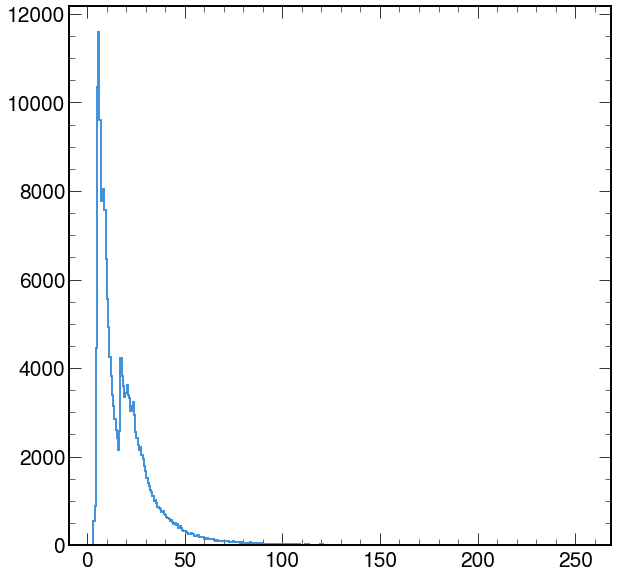

In [80]:
plt.hist(test_df["ptReco_true"], bins=400,  histtype="step", lw=2, label="Predicted");

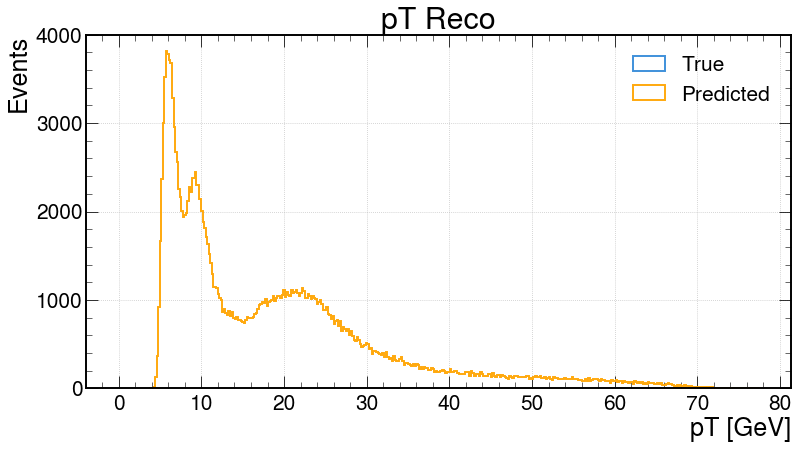

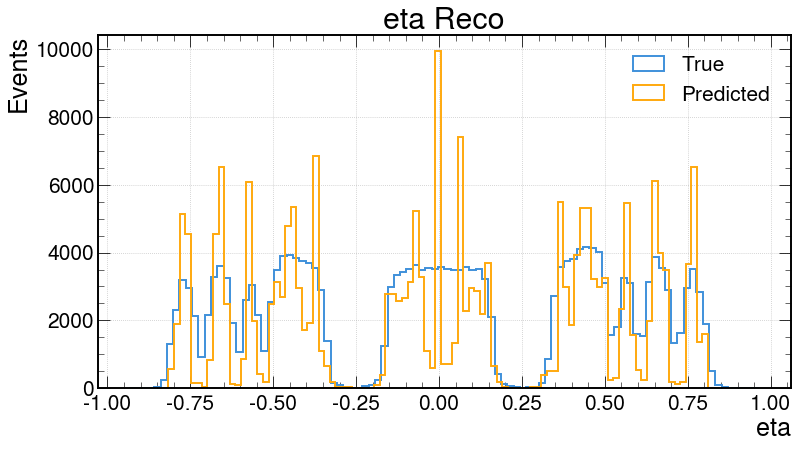

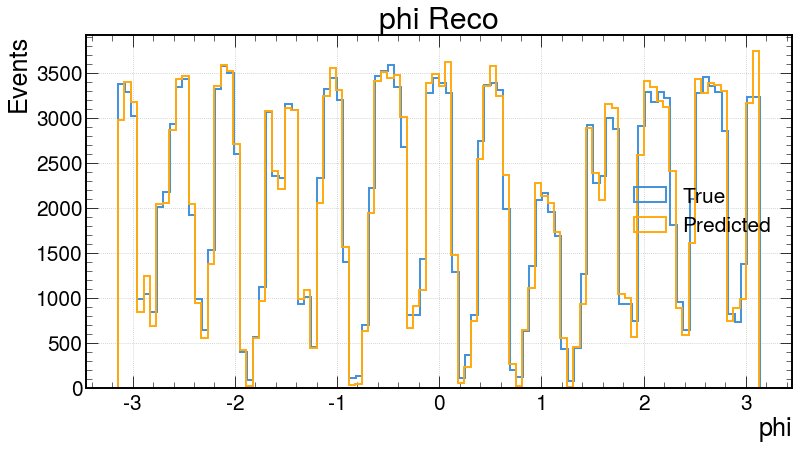

In [81]:
#plot the ptReco_true and ptReco_pred
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.hist(test_df["ptReco_true"], bins=400, range=(-0.1,0.1),  histtype="step", lw=2, label="True")
plt.hist(test_df["ptReco_pred"], bins=400,  histtype="step", lw=2, label="Predicted")
plt.xlabel("pT [GeV]")
plt.ylabel("Events")
plt.legend()
plt.title("pT Reco")
plt.grid()
plt.tight_layout()
plt.show()

#plot the etaReco_true and etaReco_pred
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.hist(test_df["etaReco_true"], bins=100,  histtype="step", lw=2, label="True")
plt.hist(test_df["etaReco_pred"], bins=100,  histtype="step", lw=2, label="Predicted")
plt.xlabel("eta")
plt.ylabel("Events")
plt.legend()
plt.title("eta Reco")
plt.grid()
plt.tight_layout()
plt.show()

#plot the phiReco_true and phiReco_pred
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.hist(test_df["phiReco_true"], bins=100,histtype="step", lw=2, label="True")
plt.hist(test_df["phiReco_pred"], bins=100, histtype="step", lw=2, label="Predicted")
plt.xlabel("phi")
plt.ylabel("Events")
plt.legend()
plt.title("phi Reco")
plt.grid()
plt.tight_layout()
plt.show()

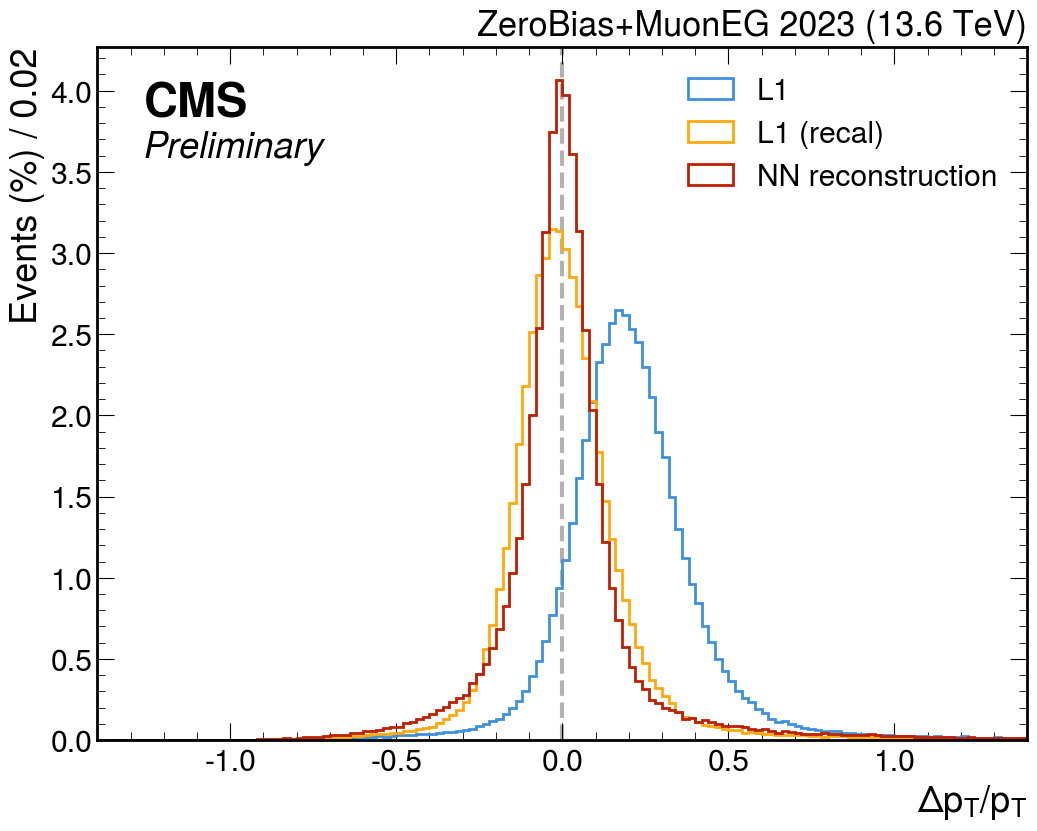

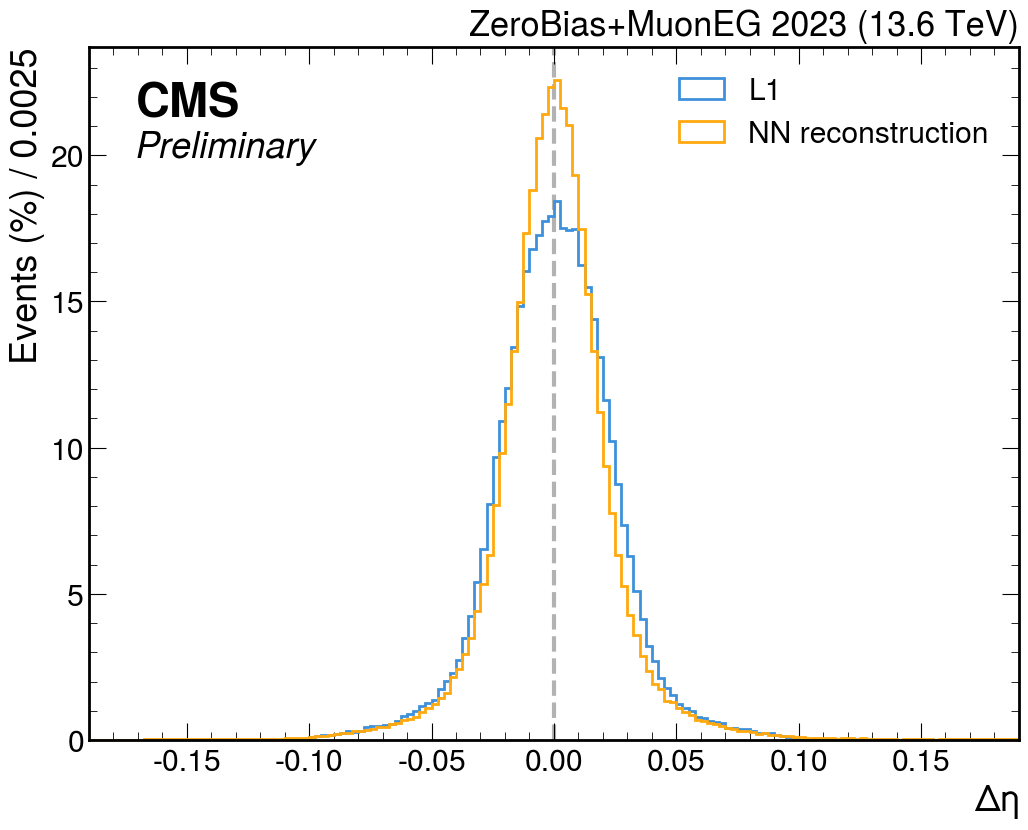

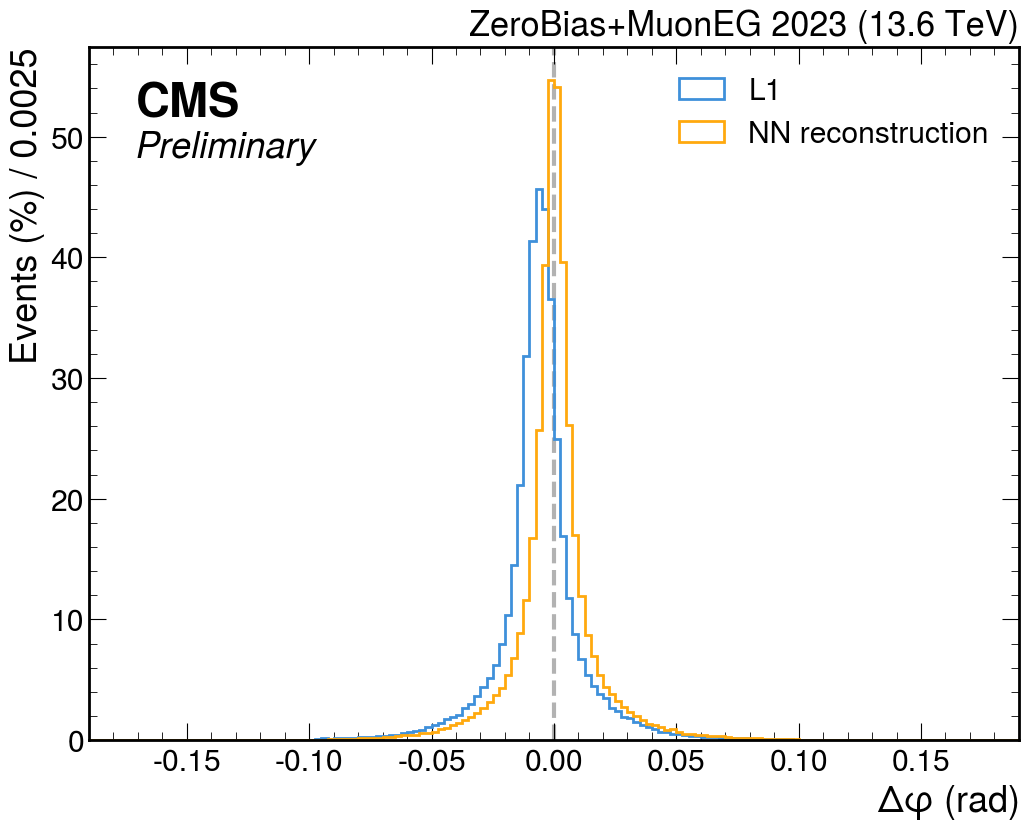

In [82]:
eta_res_pred = (test_df.etaReco_pred - test_df.etaReco_true) / test_df.etaReco_true

# if eta_res_pred < -0.5 then add 1 to shift the histogram to the right
# mask = np.where(eta_res_pred < -0.5, 1, 0)
# eta_res_pred = eta_res_pred + mask

# recompute the predicted eta
# test_df["etaReco_pred"] = test_df.etaReco_true * (1 + eta_res_pred)

pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
pt_res_l1   = (test_df.ptL1  - test_df.ptReco_true) / test_df.ptReco_true
pt_res_rec_l1   = (test_df.ptL1/1.2  - test_df.ptReco_true) / test_df.ptReco_true

eta_res_pred = (test_df.etaReco_pred - test_df.etaReco_true) 
eta_res_l1   = (test_df.etaL1   - test_df.etaReco_true)

phi_res_pred = (test_df.phiReco_pred - test_df.phiReco_true)
phi_res_l1   = (test_df.phiL1   - test_df.phiReco_true)


rlabel = "ZeroBias+MuonEG 2023 (13.6 TeV)"

xmin = -1.4
xmax = 1.4
binw = 0.02

fig, ax = plt.subplots(1,1, figsize=(12,9), dpi = 100)
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(pt_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(pt_res_rec_l1, bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1 (recal)")
plt.hist(pt_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta p_T / p_T$")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/pt_res_{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()


xmin = -0.19
xmax = 0.19
binw = 0.0025

fig, ax = plt.subplots(1,1, figsize=(12,9), dpi = 100)
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(eta_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(eta_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta \eta$")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/eta_res_{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()


xmin = -0.19
xmax = 0.19
binw = 0.0025

fig, ax = plt.subplots(1,1, figsize=(12,9), dpi = 100)
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(phi_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(phi_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta\\varphi$ (rad)")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/phi_res_{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()

### pT resolution vs pT perd true 2D histogram

In [83]:
heights.shape

(100, 150)

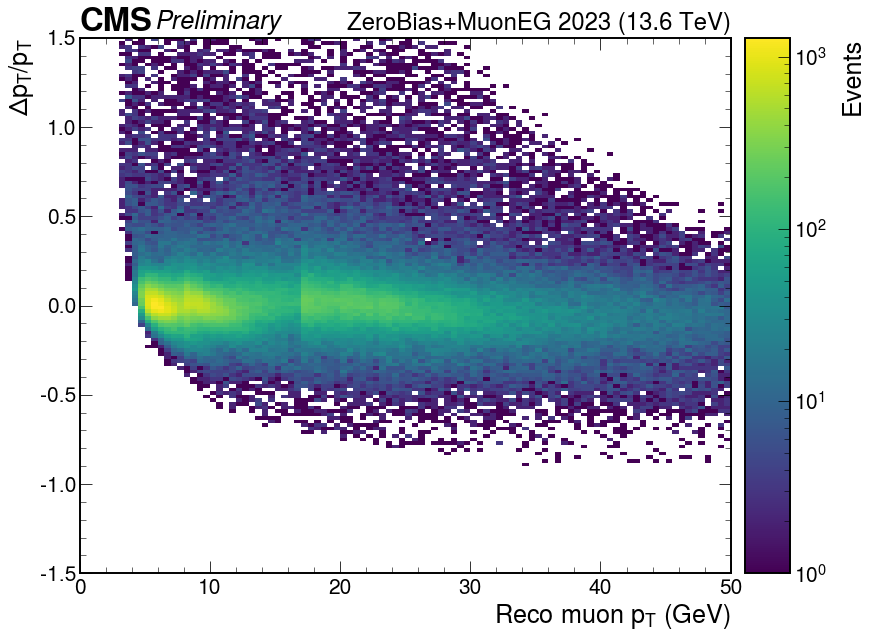

In [84]:
xmin = 0
xmax = 50
xbinw = 0.5
ymin = -1.5
ymax = 1.5
ybinw = 0.02

pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
heights, binsx, binsy = np.histogram2d(test_df.ptReco_true, pt_res_pred, bins=(np.arange(xmin, xmax+xbinw, xbinw), np.arange(ymin, ymax+ybinw, ybinw)))

fig, ax = plt.subplots(figsize=(12,9), constrained_layout=True)
hep.cms.label(label="Preliminary", data=True, year=2023, rlabel=rlabel)

hep.hist2dplot(heights, binsx, binsy, ax=ax, cmap="viridis", flow=None, norm = mpl.colors.LogNorm())
cbar = ax.collections[0].colorbar
cbar.set_label("Events", labelpad=15) # , fontsize=36)
# cbar.ax.tick_params(labelsize=36)
# Adding labels and title
plt.xlabel("Reco muon $p_T$ (GeV)")
plt.ylabel("$\Delta p_T / p_T$")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}pt_res_vs_pt_reco_true_zoom{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()

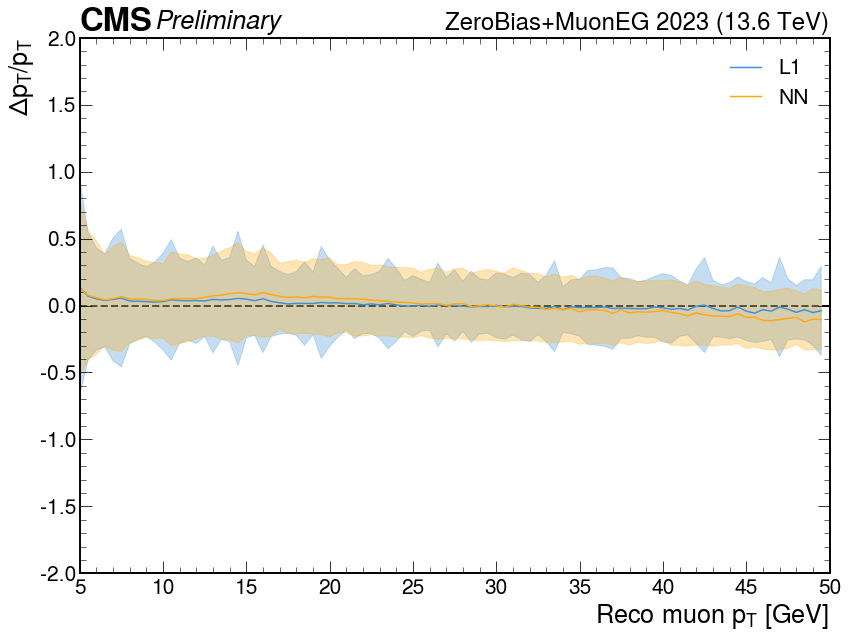

In [85]:
xmin = 0
xmax = 50
binw = 0.5

# Compute pT resolution
pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
pt_res_l1   = (test_df.ptL1 / 1.2  - test_df.ptReco_true) / test_df.ptReco_true

# Define bins for pT reco true
pt_true_bins = np.arange(xmin, xmax+binw, binw)  # From 0 to 50 GeV with bin width 1 GeV

# Initialize arrays to store average pT resolution and standard deviation in each bin
avg_pt_res_pred = np.zeros(len(pt_true_bins) - 1)
std_pt_res_pred = np.zeros(len(pt_true_bins) - 1)
avg_pt_res_l1   = np.zeros(len(pt_true_bins) - 1)
std_pt_res_l1   = np.zeros(len(pt_true_bins) - 1)


# Loop through the bins to calculate average pT resolution and standard deviation
for i in range(len(pt_true_bins) - 1):
    lower_bound = pt_true_bins[i]
    upper_bound = pt_true_bins[i + 1]
    
    # Mask data points that fall within the current bin
    mask = (test_df.ptReco_true >= lower_bound) & (test_df.ptReco_true < upper_bound)
    
    # Compute the average pT resolution for the current bin
    avg_pt_res_pred[i] = np.mean(pt_res_pred[mask])
    avg_pt_res_l1[i]   = np.mean(pt_res_l1[mask])
    
    # Compute the standard deviation for the current bin
    std_pt_res_pred[i] = np.std(pt_res_pred[mask]) # / np.sqrt(len(pt_res_pred[mask]))
    std_pt_res_l1[i]   = np.std(pt_res_l1[mask])   # / np.sqrt(len(pt_res_l1[mask]))


# Create the profile plot
fig, ax = plt.subplots(figsize=(12,9), constrained_layout=True)
hep.cms.label(ax=ax, data=True, year=2023, label="Preliminary", rlabel=rlabel)
plt.plot(pt_true_bins[:-1], avg_pt_res_l1, "-", label="L1", color="C0")
plt.fill_between(pt_true_bins[:-1], avg_pt_res_l1 - std_pt_res_l1, avg_pt_res_l1 + std_pt_res_l1, alpha=0.3, color="C0")

plt.plot(pt_true_bins[:-1], avg_pt_res_pred, "-", label="NN", color="C1")
plt.fill_between(pt_true_bins[:-1], avg_pt_res_pred - std_pt_res_pred, avg_pt_res_pred + std_pt_res_pred, alpha=0.3, color="C1")

ax.axhline(0, color="black", linestyle="--", linewidth=2, zorder=0)

# Plotting the average pT resolution with error bars

# ax.errorbar(
#     x=pt_true_bins[:-1], 
#     y=avg_pt_res_l1, 
#     yerr=std_pt_res_l1, 
#     marker='o', 
#     linestyle="",
#     markersize=12,
#     elinewidth=3,
#     capthick=3,
#     capsize=5,
#     label="L1",
#     color=PALETTE[-1],
# )


# ax.errorbar(
#     x=pt_true_bins[:-1], 
#     y=avg_pt_res_pred, 
#     yerr=std_pt_res_pred, 
#     marker='o', 
#     linestyle="",
#     markersize=12,
#     elinewidth=3,
#     capthick=3,
#     capsize=5,
#     label="NN Prediction",
#     color=PALETTE[0],
# )


# ax.legend(fontsize=36, loc="upper right")


# Adding labels and title
plt.xlabel("Reco muon $p_T$ [GeV]")
plt.ylabel("$\Delta p_T / p_T$")

# ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}pt_res_vs_pt_reco_true_profile{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.xlim(5,xmax)
plt.ylim(-2,2)
plt.legend()
plt.show()


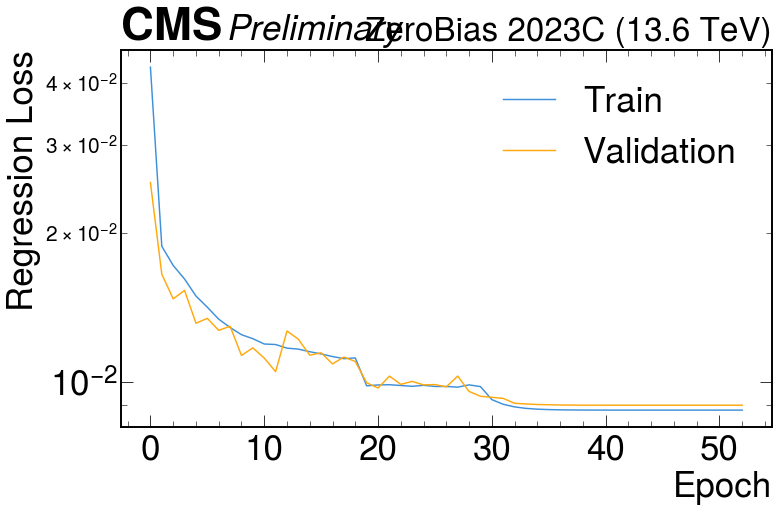

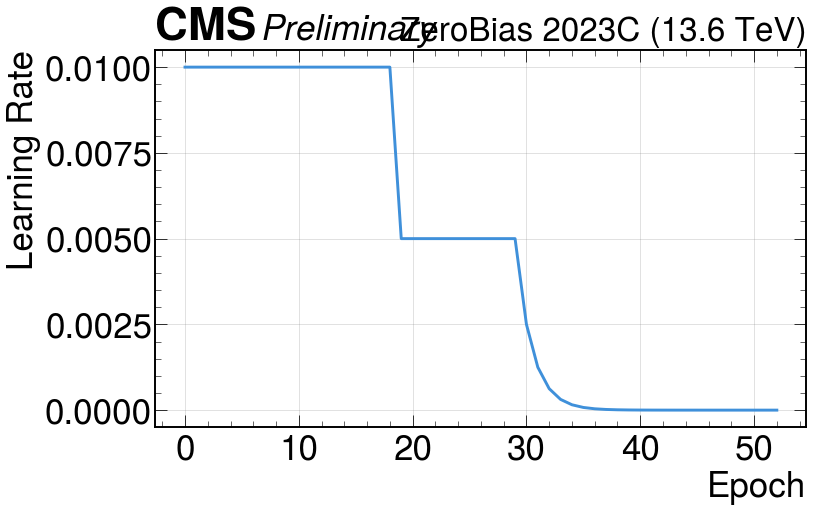

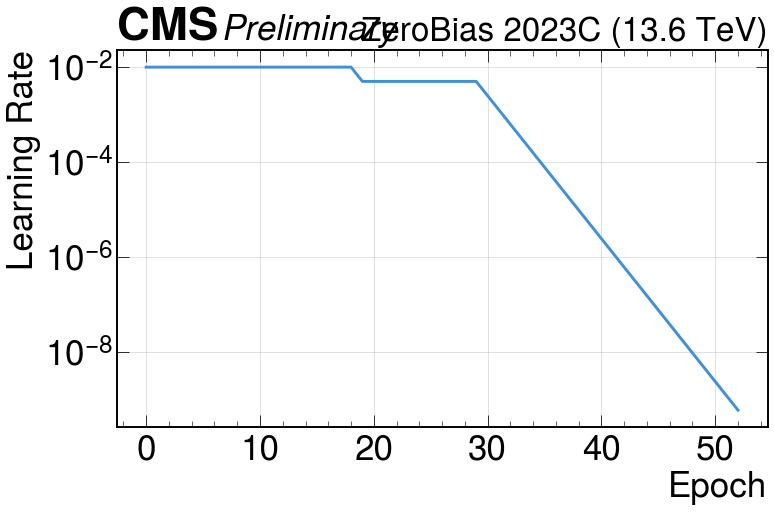

In [86]:
# plot losses
fig, ax = plt.subplots(figsize=FIGSIZE)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(train_regression_losses, label="Train")
ax.plot(val_regression_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Regression Loss", fontsize=36)
ax.legend(fontsize=36)
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)



fig, ax = plt.subplots(figsize=FIGSIZE)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(learning_rates, lw=3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Learning Rate", fontsize=36)

ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}learning_rate{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(learning_rates, lw=3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Learning Rate", fontsize=36)

ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}log_learning_rate{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

## Perform multiple trainings to compute average loss (TAKES A LOT OF TIME)

In [87]:
N_ITER = 50

In [88]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=True)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return regression_loss, classification_loss, loss

@tf.function
def val_step(features, targets):
    regression_targets = targets[:, :-1]
    classification_targets = targets[:, -1]
    reg_outputs, class_outputs = model(features, training=False)
    regression_loss = regression_criterion(regression_targets, reg_outputs)
    classification_loss = classification_criterion(classification_targets, class_outputs)
    loss = regression_weight * regression_loss + classification_weight * classification_loss
    return regression_loss, classification_loss, loss

In [89]:
full_data_ = pd.DataFrame()

for file in os.listdir(FILE_PATH):
    if file.endswith(".csv"):
        full_data_ = pd.concat([full_data_, pd.read_csv(FILE_PATH + file)], ignore_index=True)
        
full_data_ = full_data_.iloc[:, :-1]

# drop rows with ptL1 == 4.5
full_data_ = full_data_[full_data_["ptL1"] != 4.5]

# drop rows with reco eta > 1 and < -1
full_data_ = full_data_[full_data_["etaExtRecoSt2"] < 1]
full_data_ = full_data_[full_data_["etaExtRecoSt2"] > -1]

# drop rows with ptL1 > 50
full_data_ = full_data_[full_data_["ptL1"] < 50]

# drop rows with ptReco > 50
full_data_ = full_data_[full_data_["ptReco"] < 50]


# mask_1 = (full_data_.etaL1 == 0) & (np.abs(full_data_.etaExtRecoSt2) == 0)
# mask_2 = (full_data_.etaL1 != 0)

# mask = mask_1 | mask_2

# full_data_ = full_data_[mask]

full_data_["ptRecoInverse"] = 1 / full_data_["ptReco"]

full_data = full_data_[stub_features + target_features + l1_features]

full_data["chargeReco"] = full_data["chargeReco"].apply(lambda x: 0 if x == -1 else 1)

NameError: name 'stub_features' is not defined

In [ ]:
classification_criterion = losses.BinaryCrossentropy(from_logits=True)
regression_criterion     = losses.MeanAbsoluteError()

# lr scheduler
scale_factor = 0.5
patience = 5
min_loss_improvement = 0.1

classification_weight = 1
regression_weight     = 5

In [ ]:
train_regression_losses_all     = []
train_classification_losses_all = []
train_combined_losses_all       = []
val_regression_losses_all       = []
val_classification_losses_all   = []
val_combined_losses_all         = []

for i in range(N_ITER):
    
    # Hyperparameters
    input_size    = len(stub_features)
    architecture  = [input_size, 64, 32, 16, 8]
    output_size   = len(target_features)
    learning_rate = 1e-2
    num_epochs    = 300
    batch_size    = 2**10
    reg_strength  = 1e-3

    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 10  # Number of epochs to wait before stopping
    early_stopping_threshold = 1e-5  # Minimum improvement in loss function to be considered as improvement


    train_val_data, test_data = train_test_split(full_data,      test_size=0.3, random_state=42)
    train_data, val_data      = train_test_split(train_val_data, test_size=0.1, random_state=42)

    # normalize the data
    for key in normalizations.keys():
        train_data[key] = train_data[key] / normalizations[key]
        val_data[key]   = val_data[key]   / normalizations[key]
        test_data[key]  = test_data[key]  / normalizations[key]
        
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data[stub_features].values, train_data[target_features].values)).batch(batch_size).shuffle(buffer_size=len(train_data))
    val_dataset   = tf.data.Dataset.from_tensor_slices((val_data[stub_features].values, val_data[target_features].values)).batch(batch_size)
    test_dataset  = tf.data.Dataset.from_tensor_slices((test_data[stub_features].values, test_data[target_features].values)).batch(batch_size)


    # Create the model
    model = MultiTaskNN(architecture, reg_strength=reg_strength)

    # Build the model with the batch input shape
    bs = None  # None allows for variable batch size
    model.build((bs, input_size))

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    scheduler = CustomLRScheduler(
        optimizer, 
        factor=scale_factor, 
        patience=patience, 
        min_improvement=min_loss_improvement, 
        verbose=True
    )


    train_regression_losses     = []
    train_classification_losses = []
    train_combined_losses       = []
    val_regression_losses       = []
    val_classification_losses   = []
    val_combined_losses         = []

    learning_rates = []
    
    @tf.function
    def train_step(features, targets):
        with tf.GradientTape() as tape:
            regression_targets = targets[:, :-1]
            classification_targets = targets[:, -1]
            reg_outputs, class_outputs = model(features, training=True)
            regression_loss = regression_criterion(regression_targets, reg_outputs)
            classification_loss = classification_criterion(classification_targets, class_outputs)
            loss = regression_weight * regression_loss + classification_weight * classification_loss

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return regression_loss, classification_loss, loss

    @tf.function
    def val_step(features, targets):
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=False)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss
        return regression_loss, classification_loss, loss


    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        
        for features, targets in train_dataset:
            
            regression_loss, classification_loss, loss = train_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()


            
        # Note: Remember to adjust if not using batches of equal sizes
        train_loss                = running_loss                / len(train_dataset)
        train_regression_loss     = running_regression_loss     / len(train_dataset)
        train_classification_loss = running_classification_loss / len(train_dataset)

        train_regression_losses.append(train_regression_loss)
        train_classification_losses.append(train_classification_loss)
        train_combined_losses.append(train_loss)

        # Validation
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        for features, targets in val_dataset:
            
            regression_loss, classification_loss, loss = val_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()
        
        avg_val_loss                = running_loss                / len(val_dataset)
        avg_val_regression_loss     = running_regression_loss     / len(val_dataset)
        avg_val_classification_loss = running_classification_loss / len(val_dataset)
            
        val_regression_losses.append(avg_val_regression_loss)
        val_classification_losses.append(avg_val_classification_loss)
        val_combined_losses.append(avg_val_loss)
        
        
        current_lr = optimizer.lr.numpy()
        learning_rates.append(current_lr)
        
        
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Learning rate: {current_lr:.2e}")
        print(f"Train Losses - Regression: {train_regression_losses[-1]:.4f}, Classification: {train_classification_losses[-1]:.4f}, Combined: {train_combined_losses[-1]:.4f}")
        print(f"Validation Losses - Regression: {val_regression_losses[-1]:.4f}, Classification: {val_classification_losses[-1]:.4f}, Combined: {val_combined_losses[-1]:.4f}")
        print("-------------")
        
        
        scheduler.on_epoch_end(epoch, {"val_loss": avg_val_loss})

        

        # Check for early stopping based on the new criterion
        if avg_val_loss < (1 - early_stopping_threshold) * best_val_loss:  # 0.001 corresponds to 0.1%
            epochs_without_improvement = 0
            best_val_loss = min(best_val_loss, avg_val_loss)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break
        
    train_regression_losses_all.append(train_regression_losses)
    train_classification_losses_all.append(train_classification_losses)
    train_combined_losses_all.append(train_combined_losses)
    val_regression_losses_all.append(val_regression_losses)
    val_classification_losses_all.append(val_classification_losses)
    val_combined_losses_all.append(val_combined_losses)
    
    del model
    del optimizer
    del scheduler
    del train_dataset
    del val_dataset
    del test_dataset
    del train_data
    del val_data
    del test_data
    del train_val_data

Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.1081, Classification: 0.1282, Combined: 0.6685
Validation Losses - Regression: 0.0584, Classification: 0.0825, Combined: 0.3743
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0399, Classification: 0.0807, Combined: 0.2800
Validation Losses - Regression: 0.0396, Classification: 0.0756, Combined: 0.2735
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0305, Classification: 0.0767, Combined: 0.2290
Validation Losses - Regression: 0.0301, Classification: 0.0725, Combined: 0.2228
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0256, Classification: 0.0753, Combined: 0.2033
Validation Losses - Regression: 0.0229, Classification: 0.0713, Combined: 0.1856
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0234, Classification: 0.0734, Combined: 0.1903
Validation Losses - Regression: 0.0204, Classifica

KeyboardInterrupt: 

In [ ]:
# compute the mean and std of the losses for each epoch
# the lists in the lists are of different lengths, so we need to pad them with the last value
# then we can compute the mean and std

train_regression_losses_all      = [x + [x[-1]] * (max(map(len, train_regression_losses_all)) - len(x)) for x in train_regression_losses_all]
train_classification_losses_all  = [x + [x[-1]] * (max(map(len, train_classification_losses_all)) - len(x)) for x in train_classification_losses_all]
train_combined_losses_all        = [x + [x[-1]] * (max(map(len, train_combined_losses_all)) - len(x)) for x in train_combined_losses_all]

val_regression_losses_all        = [x + [x[-1]] * (max(map(len, val_regression_losses_all)) - len(x)) for x in val_regression_losses_all]
val_classification_losses_all    = [x + [x[-1]] * (max(map(len, val_classification_losses_all)) - len(x)) for x in val_classification_losses_all]
val_combined_losses_all          = [x + [x[-1]] * (max(map(len, val_combined_losses_all)) - len(x)) for x in val_combined_losses_all]

train_regression_losses_mean     = np.mean(np.array(train_regression_losses_all), axis=0)[1:]
train_regression_losses_std      = np.std(np.array(train_regression_losses_all), axis=0)[1:]
train_classification_losses_mean = np.mean(np.array(train_classification_losses_all), axis=0)[1:]
train_classification_losses_std  = np.std(np.array(train_classification_losses_all), axis=0)[1:]
train_combined_losses_mean       = np.mean(np.array(train_combined_losses_all), axis=0)[1:]
train_combined_losses_std        = np.std(np.array(train_combined_losses_all), axis=0)[1:]

val_regression_losses_mean       = np.mean(np.array(val_regression_losses_all), axis=0)[1:]
val_regression_losses_std        = np.std(np.array(val_regression_losses_all), axis=0)[1:]
val_classification_losses_mean   = np.mean(np.array(val_classification_losses_all), axis=0)[1:]
val_classification_losses_std    = np.std(np.array(val_classification_losses_all), axis=0)[1:]
val_combined_losses_mean         = np.mean(np.array(val_combined_losses_all), axis=0)[1:]
val_combined_losses_std          = np.std(np.array(val_combined_losses_all), axis=0)[1:]

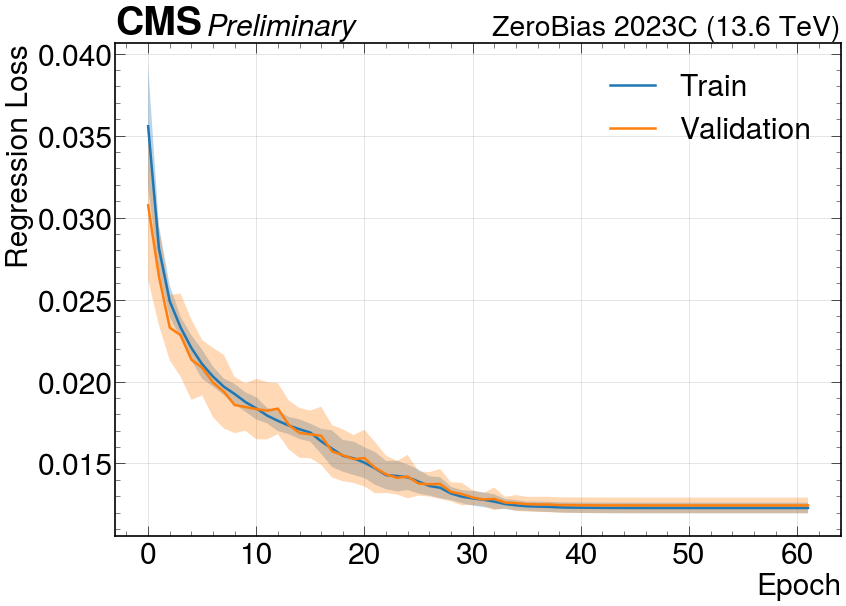

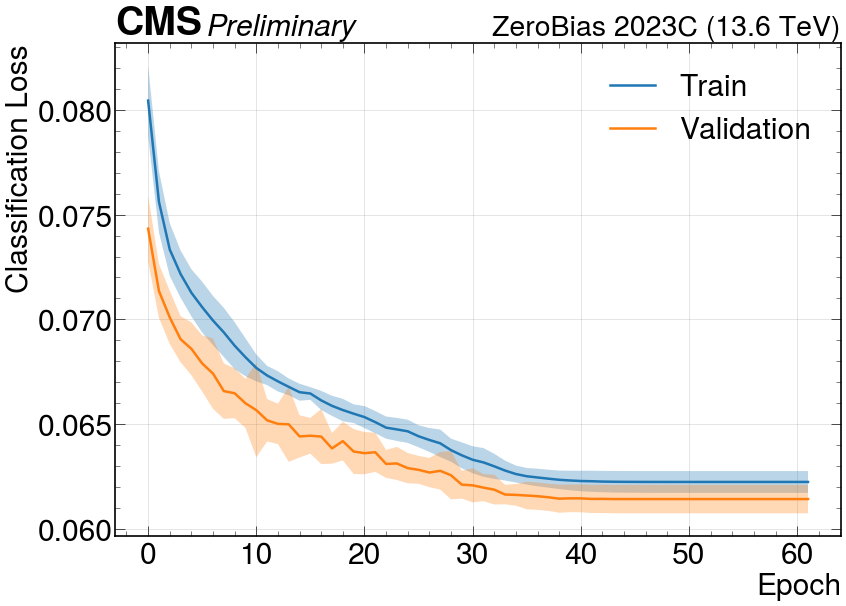

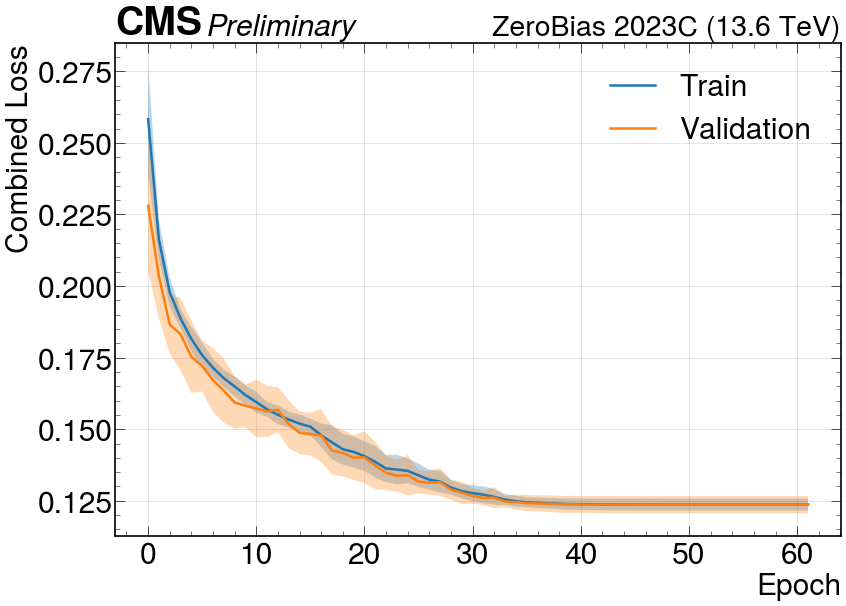

In [ ]:


# REGRESSION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_regression_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_regression_losses_mean)), train_regression_losses_mean - train_regression_losses_std, train_regression_losses_mean + train_regression_losses_std, alpha=0.3)
ax.plot(val_regression_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_regression_losses_mean)), val_regression_losses_mean - val_regression_losses_std, val_regression_losses_mean + val_regression_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Regression Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}regression_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# CLASSIFICATION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_classification_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_classification_losses_mean)), train_classification_losses_mean - train_classification_losses_std, train_classification_losses_mean + train_classification_losses_std, alpha=0.3)
ax.plot(val_classification_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_classification_losses_mean)), val_classification_losses_mean - val_classification_losses_std, val_classification_losses_mean + val_classification_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Classification Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}classification_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# COMBINED LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_combined_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_combined_losses_mean)), train_combined_losses_mean - train_combined_losses_std, train_combined_losses_mean + train_combined_losses_std, alpha=0.3)
ax.plot(val_combined_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_combined_losses_mean)), val_combined_losses_mean - val_combined_losses_std, val_combined_losses_mean + val_combined_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Combined Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}combined_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()